In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import scipy as sp
import scipy.stats
import pickle
# from lasagne.updates import adam

In [2]:
def sample_categorical(pi):
    pi_cumsum = pi.cumsum(axis = 1)
    return np.apply_along_axis( \
        lambda a: a.searchsorted(np.random.uniform(0, 1)), \
        arr = pi_cumsum, \
        axis = 1, \
    )

In [3]:
# 2d gmm w/ fixed isotropic variance and fixed cluster distn cluster means have same prior.
# infer Pr[cluster means | samples]

### HYPER PARAMETERS ###

C = 6

# mu[i] ~ Gaussian(mu_mu[i], mu_Sigma[i])
mu_mu = np.zeros((2,))
mu_sigma2 = 2
mu_Sigma = np.eye(2) * mu_sigma2
mu_Lambda = np.eye(2) / mu_sigma2
mu_rvs = [
    sp.stats.multivariate_normal(mu_mu, mu_Sigma) for _ in range(C)
]

# sigma2 fixed, intended to be small
sigma2 = 0.05
Sigma = np.eye(2) * sigma2
Lambda = np.eye(2) / sigma2

# pi categorical over clusters, fixed
pi_prob = 1 / C
pis = np.arange(C)
# pi_rv = sp.stats.bernoulli(pi_eq_1_prob)

# sample number n, fixed for NN
n = 60

### SAMPLE ###

def xs_1d_pca(xs):
    zero_mu_xs = xs - xs.mean(axis = 1, keepdims = True)
    Ts = []
    Ws = []
    for i in range(xs.shape[0]):
        U, s, V = np.linalg.svd(xs[i], full_matrices = False)
        Ws.append(V[0])
        Ts.append(U[:, 0] * s[0])
    return np.stack(Ts), np.stack(Ws)

def sort_mus_pca(mus, zs, Ws):
    size = mus.shape[0]
    mus_1d = np.einsum('ijk,ik->ij', mus, Ws) # transform mus to 1d
    mus_1d_argsort = mus_1d.argsort()
    mus = mus[np.arange(size).reshape((size, 1)), mus_1d_argsort]
    zs = mus_1d_argsort.argsort()[np.arange(size).reshape((size, 1)), zs]
    return mus, zs

def sort_xs_pca(zs, xs, Ts):
    size = xs.shape[0]
    Ts_argsort = Ts.argsort() # xs order by first principle component
    xs = xs[np.arange(size).reshape((size, 1)), Ts_argsort]
    zs = zs[np.arange(size).reshape((size, 1)), Ts_argsort]
    return zs, xs

# Essentially (observation, hidden) pair
def sample(size = 1, sort_pca = False):
    mus = np.atleast_2d(np.hstack(tuple(rv.rvs(size = size).reshape((size, 1, 2)) for rv in mu_rvs)))
    zs = np.random.choice(pis, size = (size, n))
    xs = np.random.multivariate_normal(np.zeros(2), np.eye(2), size = (size, n)) \
        * np.sqrt(sigma2) + mus[np.arange(size).reshape((size, 1)), zs]
    if sort_pca:
        Ts, Ws = xs_1d_pca(xs)
        mus, zs = sort_mus_pca(mus, zs, Ws)
        zs, xs = sort_xs_pca(zs, xs, Ts)
    return mus, zs, xs

In [4]:
### Gibbs ###

# xs are fixed observations
# mus (C, 2)
# zs  (n,)
# xs  (n, 2)
def gibbs_step(mus, zs, xs):
    # zs
    x_mus_2norm = ((xs.reshape((n, 1, 2)) - mus) ** 2).sum(axis = 2)
    unnormalized_probs_z = np.exp(- x_mus_2norm  / (2 * sigma2))
    probs_z = unnormalized_probs_z / (unnormalized_probs_z.sum(axis = 1, keepdims = True))
    new_zs = sample_categorical(probs_z).flatten()
    # mus
    new_mus = []
    for c in range(C):
        x_cs = xs[new_zs == c]
        t = np.linalg.inv(mu_Lambda + x_cs.shape[0] * Lambda)
        new_mu = np.random.multivariate_normal( \
            t.dot(mu_Lambda.dot(mu_mu) + Lambda.dot(x_cs.sum(axis = 0))), \
            t, \
        )
        new_mus.append(new_mu)
    return np.stack(new_mus), new_zs

# def pretrain_init_fn(xs):
#     xs = xs.reshape((1, 2 * n))
#     hids = pretrain_sample(xs)
#     return hids[:, :4], hids[:, 4:], xs

def gibbs(xs, init_fn = sample, num_samples = 500, sample_int = 10, \
          burn_in = 5000, plot = True):
    xs, xs_3d = xs, xs.reshape((1, n, 2))
    if plot:
        plotter = LinePlotter()
    s_mus = []
    s_zs = []
    mus, zs, _ = init_fn()
    mus, zs = mus[0], zs[0]
    for t in range(burn_in + num_samples * sample_int):
        if t >= burn_in and (t - burn_in) % sample_int == 0:
            s_mus.append(mus)
            s_zs.append(zs)
        mus, zs = gibbs_step(mus, zs, xs)
        if plot:
            plotter.update( \
                t, \
                get_log_likelihood( \
                    mus.reshape((1, C, 2)), \
                    np.atleast_2d(zs), \
                    xs_3d, \
                ) \
            )
    return np.stack(s_mus), np.stack(s_zs)

In [5]:
### Block Proposal NN ###
# Propose block_prop_C clusters given observations, all other clusters, and all
# assignments to other clusters.

import theano
import theano.tensor as T
# from theano.compile.nanguardmode import NanGuardMode


def T_logsumexp(x, axis = None, keepdims = False):
    xm = x.max(axis = axis, keepdims = True)
    return T.log(T.exp(x - xm).sum(axis = axis, keepdims = keepdims)) + xm

# propose 3 cluster
block_prop_C = 3
block_input_C = C - block_prop_C

# MDN
# nn_C cluster number
nn_C = 3

def init_T_weight(n_in, n_out, name, is_sigmoid = False, is_zero = False):
    if is_zero:
        value = np.zeros((n_in, n_out), dtype = theano.config.floatX)
    else:
        value = np.asarray(
            np.random.uniform(
                low = -np.sqrt(6. / (n_in + n_out)),
                high = np.sqrt(6. / (n_in + n_out)),
                size = (n_in, n_out)
            ),
            dtype = theano.config.floatX
        )
    if is_sigmoid:
        value *= 4
    w = theano.shared(value = value, name = name + '_w', borrow = True)
    b = theano.shared(
        value = np.zeros((n_out,), dtype = theano.config.floatX),
        name = name + '_b',
        borrow = True,
    )
    return w, b

n_in = n * 2 + n + block_input_C * 2
# nn_C clusters of block_prop_C isotropic 2d Gaussians
n_out = nn_C + nn_C * (block_prop_C * 3)
n_mid = max(n_in, n_out) * 3

# NOTE: mid means middle (hidden) layer

# weights
w_im, b_im = init_T_weight(n_in, n_mid, 'in2mid')
w_mo, b_mo = init_T_weight(n_mid, n_out, 'mid2out')

get_im_ws = theano.function([], [w_im, b_im])
get_mo_ws = theano.function([], [w_mo, b_mo])

# dump & load
get_all_ws = theano.function([], [w_im, b_im, w_mo, b_mo])
w_im_file, b_im_file = T.dmatrix('w_im_file'), T.dvector('b_im_file')
w_mo_file, b_mo_file = T.dmatrix('w_mo_file'), T.dvector('b_mo_file')
set_all_ws = theano.function( \
    [w_im_file, b_im_file, w_mo_file, b_mo_file],
    [w_im_file, b_im_file, w_mo_file, b_mo_file],
    updates = [
        (w_im, w_im_file), (b_im, b_im_file),
        (w_mo, w_mo_file), (b_mo, b_mo_file),
    ],
)

import os.path

def dump_weights(file_name):
    if os.path.isfile(file_name):
        print("{} already exists, abort.".format(file_name))
        return
    with open(file_name, 'wb') as f:
        pickle.dump(get_all_ws(), f)
    print('Dumped to file {}'.format(file_name))

def load_weights(file_name):
    with open(file_name, 'rb') as f:
        set_all_ws(*pickle.load(f))
    print('Loaded from file {}'.format(file_name))

# batch size k
flat_xs = T.dmatrix('flat_xs')                  # (k, 2 * n)
pzs = T.dmatrix('pzs')                          # (k, n * C) = processed zs s.t.
                                                #              if z = proposing
                                                #              cluster, z := -1
flat_input_mus = T.dmatrix('flat_input_mus')    # (k, block_input_C * 2)
flat_prop_mus = T.dmatrix('flat_prop_mus')      # (k, n + 4) = mus + hids

# ignore constant terms.
def get_log_likelihood(mus, zs, xs):
    k = xs.shape[0]
    l = sum(mu_rvs[i].logpdf(mus[:, i]) for i in range(mus.shape[1]))
    l -= ((xs - mus[np.arange(k).reshape((k, 1)), zs]) ** 2).sum(axis = (1, 2)) / (2 * sigma2)
    return l.reshape((k, 1))
#     # assume Bernoulli(0.5) on zs, so ignore

# Neural net

# activation
MIN_SIGMA2 = 0.00001

# T_out has shape (k, n_out)
def T_in_to_mus_distns(T_in):
    T_mid = T_in.dot(w_im) + b_im
    T_out = T_mid.dot(w_mo) + b_mo
    distns = []
    at = 0
    distns.append(T.nnet.softmax(T_out[:, at : at + C]))
    at += nn_C
    for _ in range(nn_C):
        # mus
        for __ in range(block_prop_C):
            distns.append(T_out[:, at : at + 2])
            at += 2
            distns.append(T.nnet.elu(T_out[:, at : at + 1]) + 1 + MIN_SIGMA2)
            at += 1
    return distns

def T_mus_cluster_prop_log_probs(distns, flat_prop_mus):
    a = distns[0] # clusters
    distn_at = 1        # distns idx
    cluster_log_probs = []
    for c in range(nn_C):
        l = T.log(a[:, [c]])
        for mu_i in range(block_prop_C):
            # mu
            mus = flat_prop_mus[:, (mu_i * 2):(mu_i * 2 + 2)]
            mu_mus, mu_sigma2s = distns[distn_at], distns[distn_at + 1]
            l -= T.sqr(mus - mu_mus).sum(axis = 1, keepdims = True) / (2 * mu_sigma2s) + np.log(2 * np.pi) + T.log(mu_sigma2s)
            distn_at += 2
        cluster_log_probs.append(l)
    return T.concatenate(cluster_log_probs, axis = 1)

# ``forward''
T_in = T.concatenate([flat_xs, pzs, flat_input_mus], axis = 1)
mus_distns = T_in_to_mus_distns(T_in)
mus_cluster_prop_log_probs = T_mus_cluster_prop_log_probs(mus_distns, flat_prop_mus)
mus_prop_log_prob = T_logsumexp(mus_cluster_prop_log_probs, axis = 1, keepdims = True)

get_mus_distns = theano.function([flat_xs, pzs, flat_input_mus], mus_distns)
# get_mus_cluster_prop_log_probs = theano.function([flat_xs, pzs, flat_input_mus, flat_prop_mus], mus_cluster_prop_log_probs)
get_mus_prop_log_prob = theano.function([flat_xs, pzs, flat_input_mus, flat_prop_mus], mus_prop_log_prob)

# ``backward'' using flat_prop_mus as part of input
# for backward proposal probability calculation in MH
T_in_back = T.concatenate([flat_xs, pzs, flat_prop_mus], axis = 1)
mus_distns_back = T_in_to_mus_distns(T_in_back)
mus_cluster_prop_log_probs_back = T_mus_cluster_prop_log_probs(mus_distns_back, flat_input_mus)
mus_prop_log_prob_back = T_logsumexp(mus_cluster_prop_log_probs_back, axis = 1, keepdims = True)

In [11]:
# NN training

train_rate = T.dscalar('train_rate')
log_l = T.dmatrix('log_l') # used to normalize training data skew by assumin non-informative prior

# pretrain
pretrain_target = (mus_prop_log_prob / T.exp(log_l + 95)).mean()
weights = (w_im, b_im, w_mo, b_mo)
grads = tuple(T.grad(pretrain_target, w) for w in weights)
get_pretrain_target = theano.function([flat_xs, pzs, flat_input_mus, flat_prop_mus, log_l], pretrain_target)
get_pretrain_grads = theano.function([flat_xs, pzs, flat_input_mus, flat_prop_mus, log_l], grads)
pretrain = theano.function( \
    [flat_xs, pzs, flat_input_mus, flat_prop_mus, log_l, train_rate], \
    [pretrain_target, train_rate], \
    # updates = adam(-pretrain_target, x_weights),
    updates = [
        (w, w + train_rate * gw) for w, gw in zip(weights, grads)
    ],
    # mode = NanGuardMode(nan_is_error=True, inf_is_error=True, big_is_error=True)
)

def process_z(zs, prop_idxs):
    zs = zs.copy()
    for i, idxs in enumerate(prop_idxs):
        for idx in idxs:
            zs[i, zs[i, :] == idx] = -1
    zs[zs != -1] = 0
    return zs

def sample_to_pretrain_data(mus, zs, xs, prop_idxs = None):
    k = xs.shape[0]
    flat_xs = xs.reshape((k, n * 2))
    if prop_idxs is None:
        prop_idxs = np.stack([np.random.choice(C, block_prop_C, replace = False) for _ in range(k)])
#     import pdb; pdb.set_trace()
    prop_mask = np.zeros((k, C), dtype = bool)
    prop_mask[np.arange(k)[:, None], prop_idxs] = True
    flat_input_mus = mus[np.invert(prop_mask)].reshape((k, block_input_C * 2))
    flat_prop_mus = mus[prop_mask].reshape((k, block_prop_C * 2))
    pzs = process_z(zs, prop_idxs)
    return flat_xs, pzs, flat_input_mus, flat_prop_mus, prop_idxs

def pretrain_true(batch_size, T = 5000, training_rate_fn = lambda t: 1 / (200 + t / 3), plot_interval = 50):
    if plot_interval:
        plotter = LinePlotter('linear', plot_interval)
    t = 0
    while t < T:
        mus, zs, xs = sample(batch_size, True)
        flat_xs, pzs, flat_input_mus, flat_prop_mus, prop_idxs = sample_to_pretrain_data(mus, zs, xs)
        log_l = get_log_likelihood(mus, zs, xs)
#         import pdb; pdb.set_trace()
        old_target, _ = pretrain(flat_xs, pzs, flat_input_mus, flat_prop_mus, log_l, training_rate_fn(t))
        target = get_pretrain_target(flat_xs, pzs, flat_input_mus, flat_prop_mus, log_l)
        if plot_interval:
            plotter.update(t, target)
        else:
            print(t, old_target, target)
        t += 1

In [7]:
### Blocb Proposal MH ###

# xs are fixed observations
# mus (C, 2)
# zs  (n,)
# xs  (n, 2)
# each step:
#   randomly split into block_prop_C cluster (assume C = 2 * block_prop_C here)
#   propose clusters using nn
#   propose zs using usual gibbs

# returns (k, block_prop_C, 2)
def sample_from_distns(distns):
    k = distns[0].shape[0]
    a = distns[0]
    # sample as
    c = sample_categorical(a)
    distn_at = c * 2 * block_prop_C + 1
    # mus
    mu_mus = np.stack(distns[distn_at : distn_at + 2 * block_prop_C : 2], axis = 1) # (k, block_prop_C, 2)
    distn_at += 1
    mu_sigma2s = np.stack(distns[distn_at : distn_at + 2 * block_prop_C : 2], axis = 1) # (k, block_prop_C, 1)
    return np.random.randn(k, block_prop_C, 2) * mu_sigma2s + mu_mus

def mh_clusters(mus, zs, xs, prop_idxs, Ws):
    flat_xs, pzs, flat_input_mus, flat_prop_mus, prop_idxs = sample_to_pretrain_data(mus, zs, xs, prop_idxs)
    

def nn_block_gibbs_step(mus, zs, xs, Ws):
    # zs
    x_mus_2norm = ((xs.reshape((n, 1, 2)) - mus) ** 2).sum(axis = 2)
    unnormalized_probs_z = np.exp(- x_mus_2norm  / (2 * sigma2))
    probs_z = unnormalized_probs_z / (unnormalized_probs_z.sum(axis = 1, keepdims = True))
    new_zs = sample_categorical(probs_z).flatten()
    # mus
    new_mus = []
    for c in range(C):
        x_cs = xs[new_zs == c]
        t = np.linalg.inv(mu_Lambda + x_cs.shape[0] * Lambda)
        new_mu = np.random.multivariate_normal( \
            t.dot(mu_Lambda.dot(mu_mu) + Lambda.dot(x_cs.sum(axis = 0))), \
            t, \
        )
        new_mus.append(new_mu)
    return np.stack(new_mus), new_zs

def nn_block_gibbs(xs, init_fn = sample, num_samples = 500, sample_int = 10, \
          burn_in = 5000, plot = True):
    # all ndarrays now with (size, ...)
    xs = xs.reshape((1, n, 2))
    _, Ws = xs_1d_pca(xs)
    if plot:
        plotter = LinePlotter()
    s_mus = []
    s_zs = []
    mus, zs, _ = init_fn()
    mus, zs = sort_mus_pca(mus, zs, Ws)
    for t in range(burn_in + num_samples * sample_int):
        if t >= burn_in and (t - burn_in) % sample_int == 0:
            s_mus.append(mus[0])
            s_zs.append(zs[0])
        mus, zs = nn_block_gibbs_step(mus, zs, xs, Ws)
        if plot:
            plotter.update( \
                t, \
                get_log_likelihood( \
                    mus.reshape((1, C, 2)), \
                    np.atleast_2d(zs), \
                    xs_3d, \
                ) \
            )
    return np.stack(s_mus), np.stack(s_zs)

In [8]:
### PLOT ###
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from IPython import display

def test_pretrain_visualize():
    mus, zs, xs = sample(sort_pca = True)
    flat_xs, pzs, flat_input_mus, flat_prop_mus, prop_inds = sample_to_pretrain_data(mus, zs, xs)
    # s_mus, s_zs = gibbs(xs, plot = False)
    # s_xs = np.repeat(xs.reshape((1, 2 * n)), s_mus.shape[0], axis = 0)
    # scatter_mus(s_mus)
    for c in range(C):
        if c in prop_inds:
            scatter_xs(xs[zs == c], color = 'black')
        else:
            scatter_xs(xs[zs == c], color = 'grey')
            scatter_xs(mus[0, [c]], color = 'black', marker = 'x')
    plt.axis('equal')
    contour_distns(get_mus_distns(flat_xs, pzs, flat_input_mus))

class LinePlotter:
    def __init__(self, yscale = 'log', update_interval = 50):
        self.data = [], []
        self.update_interval = update_interval
        plt.axes()
        plt.yscale(yscale)
        self.draw()

    def draw(self):
        plt.gca().cla() 
        plt.plot(*self.data)
        display.clear_output(wait = True)
        display.display(plt.gcf())

    def update(self, x, y, force = False):
        self.data[0].append(x)
        self.data[1].append(y)
        if force or len(self.data[0]) % self.update_interval == 0:
            self.draw()

    def finish(self):
        self.draw()
        plt.ioff()

COLOR_CYCLE = ['r', 'c', 'm', 'y', 'k', 'g']

def contour_distns(distns, countour_num = block_prop_C, delta = 0.01):
    x = np.arange(plt.xlim()[0] - 1, plt.xlim()[1] + 1, delta)
    y = np.arange(plt.ylim()[0] - 1, plt.ylim()[1] + 1, delta)
    X, Y = np.meshgrid(x, y)
    a = distns[0][0]
    at = 1
    mus_p = [0 for _ in range(countour_num)]
    for nn_c in range(nn_C):
        for c in range(countour_num):
            mu_mu, mu_sigma = distns[at][0], np.sqrt(distns[at + 1][0, 0])
            mus_p[c] += a[nn_c] * mlab.bivariate_normal(X, Y, mu_sigma, mu_sigma, *mu_mu)
            at += 2
    for c in range(countour_num):
        mu_contour = plt.contour(X, Y, mus_p[c], 6, colors = COLOR_CYCLE[c % len(COLOR_CYCLE)])
        plt.clabel(mu_contour, fontsize = 9, inline = 1)

def scatter_xs(xs, zs = None, color = 'black', marker = 'o'):
    assert zs is None or zs.shape[0] == 1
    n = xs.size / 2
    if len(xs.shape) == 3:
        xs = xs.reshape((n, 2))
    if zs is None:
        plt.scatter(xs[:, 0], xs[:, 1], color = color, marker = marker)
    else:
        zs = zs.reshape(n)
        for c in range(C):
            xcs = xs[zs == c]
            plt.scatter(xcs[:, 0], xcs[:, 1], color = COLOR_CYCLE[c % len(COLOR_CYCLE)], edgecolor = 'black', marker = marker, linewidth = '1')


# def scatter_mus(s_mus):
#     plt.scatter(s_mus[:, 0], s_mus[:, 1], color = 'blue')
#     plt.scatter(s_mus[:, 2], s_mus[:, 3], color = 'red')


In [27]:
load_weights('save8.pkl')

Loaded from file save8.pkl


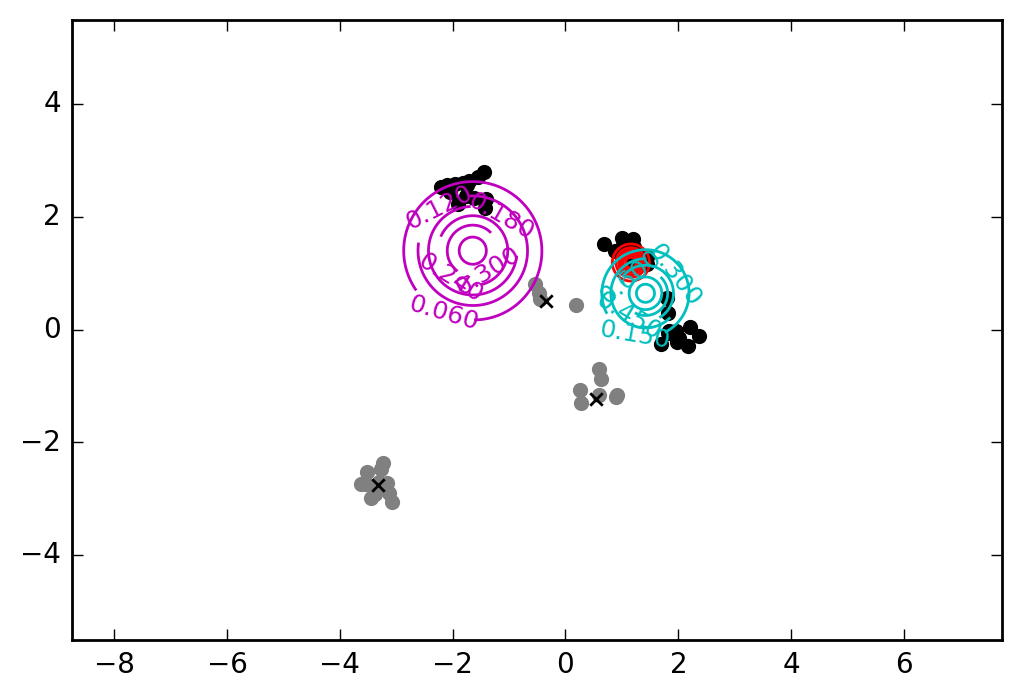

In [25]:
test_pretrain_visualize()

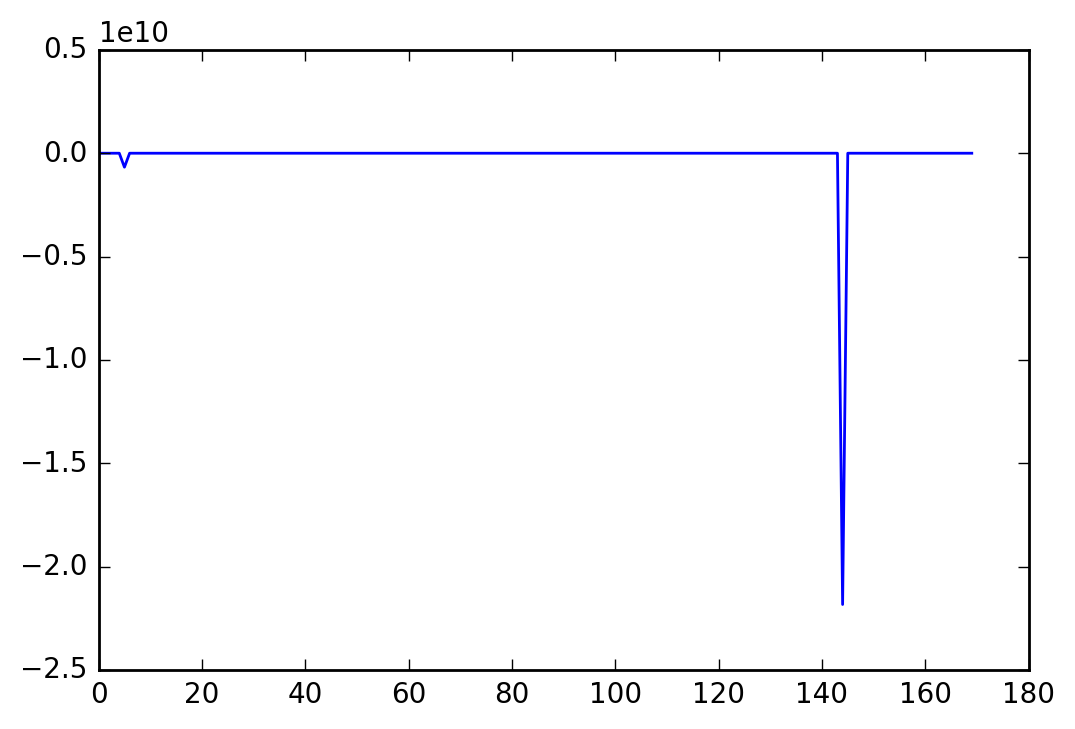

In [ ]:
pretrain_true(10, T = 2000, training_rate_fn = lambda t: 0.0000000001, plot_interval = 100)